In [1]:
import pickle as pkl
import numpy as np
from celluloid import Camera
import pdb
import scipy
import ipdb
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from scipy.spatial.transform import Rotation as R
from matplotlib.patches import Rectangle
from IPython.display import HTML
import cv2

In [2]:
def get_angle2(pos1, pos2):
    dx = pos1[0] - pos2[0]
    dy = pos1[2] - pos2[2]
    return 180./math.pi * np.arctan2(dy, dx)

def get_angle(rot):
    rot = R.from_quat(rot)
    euler = rot.as_euler('xzy')
    # dchange = np.sin(euler[1])*np.cos(euler[0]), np.cos(euler[1])*np.sin(euler[0])
    # dchange = np.sin(euler[1]+euler[0]), np.cos(euler[1]+euler[0])
    x = np.cos(euler[2])*np.cos(euler[1])
    y = np.sin(euler[2])*np.cos(euler[1])
    z = np.sin(euler[1])
    dchange = y, x
    return np.arctan2(x,y)*180 / math.pi
    
def plot_graph_2d(graph, ax, goal_ids, belief_ids=[], c_obs_ids=None):


    #nodes_interest = [node for node in graph['nodes'] if 'GRABBABLE' in node['properties']]
    goals = [node for node in graph['nodes'] if node['class_name'] in goal_ids]
    
    belief_obj = [node for node in graph['nodes'] if node['id'] in belief_ids]

    # container_surf = dict_info['objects_inside'] + dict_info['objects_surface']
#     pdb.set_trace()
    container_surf = ['kitchentable', 'cabinet', 'kitchencabinet', 'kitchencabinets', 'fridge', 'bathroomcabinet', 'stove', 'coffeetable', 'dishwasher']
    container_and_surface = [node for node in graph['nodes'] if node['class_name'] in container_surf]
    container_open = [node for node in graph['nodes'] if node['class_name'] in container_surf and 'OPEN' in node['states']]
    container_open_id = [n['id'] for n in container_open]
    c_obs_ids = [c for c in c_obs_ids if c not in container_open_id]
    obs_objects = [node for node in graph['nodes'] if node['id'] in c_obs_ids and node['category'] not in ['Rooms', 'Doors'] and node['class_name'] != 'character']
    
    
    node_char = [node for node in graph['nodes'] if node['id'] == 1][0]
#     for ob in obs_objects:
#         pos_char = node_char['obj_transform']['position']
#         angle_char = get_angle(node_char['obj_transform']['rotation'])
#         print(ob['class_name'], get_angle2(ob['obj_transform']['position'], pos_char), angle_char)
    
    #grabbed_obj = [node for node in graph['nodes'] if node['class_name'] in dict_info['objects_grab']]
    rooms = [node for node in graph['nodes'] if 'Rooms' == node['category']]


    # containers and surfaces
    # visible_nodes = [node for node in graph['nodes'] if node['id'] in visible_ids and node['category'] != 'Rooms']
    # action_nodes = [node for node in graph['nodes'] if node['id'] in action_ids and node['category'] != 'Rooms']

    # goal_nodes = [node for node in graph['nodes'] if node['class_name'] == 'cupcake']

    # Character
    # char_node = [node for node in graph['nodes'] if node['id'] == char_id][0]

    
    add_boxes(rooms, ax, points=None, rect={'alpha': 0.1})
    
        
    if len(container_and_surface) > 0:
        add_boxes(container_and_surface, ax, points=None, rect={'fill': False, 'edgecolor': 'blue', 'alpha': 0.3})
        
    if len(container_open) > 0:
#         print("HERE")
        add_boxes(container_open, ax, points=None, rect={'fill': False, 'edgecolor': 'orange', 'alpha': 1.0})
        
    #add_boxes([char_node], ax, points=None, rect={'facecolor': 'yellow', 'edgecolor': 'yellow', 'alpha': 0.7})
    #add_boxes(visible_nodes, ax, points={'s': 2.0, 'alpha': 1.0}, rect={'fill': False,
    #                     
    
    #add_boxes(action_nodes, ax, points={'s': 3.0, 'alpha': 1.0, 'c': 'red'})


    #bad_classes = ['character']
    if len(obs_objects):
        add_boxes(obs_objects, ax, points=None, rect={'fill': False, 'edgecolor': 'green', 'alpha': 0.5})
    
    if len(goals) > 0:
        add_boxes(goals, ax, points={'s':  40.0, 'alpha': 1.0, 'edgecolors': 'magenta', 'facecolors': 'none', 'linewidth': 1.0})
    if len(belief_obj) > 0:
        add_boxes(belief_obj, ax, points={'s':  30.0, 'alpha': 1.0, 'edgecolors': 'blue', 'facecolors': 'none', 'linewidth': 1.0})
    
    ax.set_aspect('equal')
    bx, by = get_bounds([room['bounding_box'] for room in rooms])

    maxsize = max(bx[1] - bx[0], by[1] - by[0])
    gapx = (maxsize - (bx[1] - bx[0])) / 4.
    gapy = (maxsize - (by[1] - by[0])) / 4.

    ax.set_xlim(bx[0]-gapx, bx[1]+gapx)
    ax.set_ylim(by[0]-gapy, by[1]+gapy)
    ax.apply_aspect()
    
def add_box(nodes, args_rect):
    rectangles = []
    centers = [[], []]
    for node in nodes:
        cx, cy = node['bounding_box']['center'][0], node['bounding_box']['center'][2]
        w, h = node['bounding_box']['size'][0], node['bounding_box']['size'][2]
        minx, miny = cx - w / 2., cy - h / 2.
        centers[0].append(cx)
        centers[1].append(cy)
        if args_rect is not None:
            rectangles.append(
                Rectangle((minx, miny), w, h, **args_rect)
            )
    return rectangles, centers


def add_boxes(nodes, ax, points=None, rect=None):
    rectangles = []
    rectangles_class, center = add_box(nodes, rect)
    rectangles += rectangles_class
    if points is not None:
        ax.scatter(center[0], center[1], **points)
    if rect is not None:
        ax.add_patch(rectangles[0])
        collection = PatchCollection(rectangles, match_original=True)
        ax.add_collection(collection)
        
def get_bounds(bounds):
    minx, maxx = None, None
    miny, maxy = None, None
    for bound in bounds:
        bgx, sx = bound['center'][0] + bound['size'][0] / 2., bound['center'][0] - bound['size'][0] / 2.
        bgy, sy = bound['center'][2] + bound['size'][2] / 2., bound['center'][2] - bound['size'][2] / 2.
        minx = sx if minx is None else min(minx, sx)
        miny = sy if miny is None else min(miny, sy)
        maxx = bgx if maxx is None else max(maxx, bgx)
        maxy = bgy if maxy is None else max(maxy, bgy)
    return (minx, maxx), (miny, maxy)

In [3]:
def visualize_trajectory(file_path=None, gen_vid=False, plot_belief=False, belief_id=None, 
                         full_obs=False, plot_img=False, frame_end=-1, plot_special_actions=False):
    char_id = 1
    if belief_id is None:
        plot_belief = False
    with open(file_path, 'rb') as f:
        content = pkl.load(f)
    
    goal_objs = [x.split('_')[1] for x,y in content['goals'][0].items() if y > 0]
    obs_ids = content['obs']
    
    
    observations = content['graph']
    
    # Get xy coordinates of the agent
    if 'obj_transform' in observations[0]['nodes'][0]:
#         ipdb.set_trace()
        coords = [[node['obj_transform'] for node in obs['nodes'] if node['id'] == char_id][0] for obs in observations]
        rots = [get_angle(coord['rotation']) for coord in coords]
        xy = np.array([[coord['position'][0],coord['position'][2]] for coord in coords])
    else:
        coords = [[node['bounding_box'] for node in obs['nodes'] if node['id'] == char_id][0] for obs in observations]
        rots = None
        xy = np.array([[coord['center'][0],coord['center'][2]] for coord in coords])
        
    n = 150
    colors = plt.cm.jet(np.linspace(0,1,n))
    if plot_img:
        fig = plt.figure(figsize=(12,6))
#         fig, axes = plt.subplots(2)
#         ax = axes[0]
#         ax_img = axes[1]
        grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.1)
        
        ax = fig.add_subplot(grid[:, :2])
        ax.axis('off')
        ax_img = fig.add_subplot(grid[1, 2])
        ax_img.axis('off')

    # Plot other info, only relevant for the planenr
    elif not plot_belief:
        fig = plt.figure(figsize=(12,9))
        ax = plt.axes()
        plt.axis('off')
    else:
        fig = plt.figure(figsize=(12,6))
        grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.1)
        id_object = belief_id
        if False:
            try:
                #pass
                id_object = int(content['subgoals'][0][-1][0].split('_')[1])
            except:
                #pass
                # ipdb.set_trace()
                id_object = int(content['subgoals'][0][0][-1].split('_')[1])
        ax = fig.add_subplot(grid[:, :2])
        ax.axis('off')
        ax_belief = fig.add_subplot(grid[1, 2])
        ax_belief2 = fig.add_subplot(grid[0, 2])
        id2name = {node['id']: node['class_name'] for node in content['init_unity_graph']['nodes']}
    
    if gen_vid:
        camera = Camera(fig)
    steps = len(xy)
    steps_total = list(range(len(xy)))
#     steps_total = steps_total[-10:]
    if not gen_vid:
        steps_total = [len(xy)-1]
        if frame_end != -1:
            steps_total = [frame_end]
        
    if plot_img:
        steps_total[-1] = steps_total[-1] - 1
    
    print(steps_total)
    for steps_t in tqdm(steps_total):
        if plot_img:
            folder = file_path.replace('/logs_episode', '/img/logs_episode').replace('.pik', '/')
            img_path = folder + 'img_{:04d}.png'.format(steps_t)
#             print(img_path)
            img_tensor = cv2.imread(img_path)[:, :, ::-1]
#             print(img_tensor.shape)
            ax_img.imshow(img_tensor)
        if obs_ids is not None:
            try:
                c_obs_ids = obs_ids[steps_t]
            except:
                c_obs_ids = obs_ids[-1]
        if belief_id is None:
            belief_ids = []
        else:
            belief_ids = [belief_id]
            
        # Plot the scene
        plot_graph_2d({'nodes': observations[steps_t]['nodes']}, ax, goal_objs, belief_ids, c_obs_ids)
        if plot_belief and steps_t < len(content['belief'][0]):
            belief_object = content['belief'][0][steps_t]
            belief_room = content['belief_room'][0][steps_t]
            do_plot_belief(belief_object, id2name, id_object, ax_belief)
            do_plot_belief2(belief_room, id2name, id_object, ax_belief2)

        
        its = steps_t
        
#         ax.scatter(cxy[:,0], cxy[:, 1], color=colors[its], s=50, marker= (3, 0, 270+angle))
        
        for steps in range(steps_t+1):
            it = steps

            if it > 0:
                cxy = xy[it-1:it+1,:]
                ax.plot(cxy[:,0], cxy[:, 1], '--', color=colors[min(it, len(colors)-1)], )
                if not gen_vid:
                    ax.plot(cxy[-1:,0], cxy[-1:, 1], '.', color=colors[min(it, len(colors)-1)], )
                

        if plot_special_actions:
            steps_grab = [ls for ls in range(steps_t) if 'grab' in content['action'][0][ls]]
            steps_open = [ls for ls in range(steps_t) if 'open' in content['action'][0][ls]]
            # Grab actions
            ax.plot(xy[steps_grab,0], xy[steps_grab, 1], '*', color='limegreen', )
            # Put actions
            ax.plot(xy[steps_open,0], xy[steps_open, 1], 'p', color='y', )
        
        
        cxy = xy[its:its+1,:]
        if rots is not None:
            angle = rots[its]
            ax.scatter(cxy[:,0]+0.3*np.cos(angle*np.pi/180.), cxy[:, 1]+0.3*np.sin(angle*np.pi/180), color='red', s=15)

        else:
            angle = 0
        
        ax.scatter(cxy[:,0], cxy[:, 1], color='cyan', s=50)

        if gen_vid:
            camera.snap()
    if gen_vid:
        if '/' in file_path:
            dir_name, fname = file_path.split('/')[-2:]
        else:
            dir_name, fname = '', file_path
        fname = fname.replace('.pik', '')
        
        fn = '{}_{}.mp4'.format(dir_name, fname)
        print(fn)
        final = camera.animate()
        final.save(fn)
        return final
    return None

def do_plot_belief(belief_object, id2name, id_object, currax):
#     currax.clear()
    belief_curr_object = belief_object[id_object]['INSIDE']
    names = belief_curr_object[0]
    probs = belief_curr_object[1]
    names = [id2name[name] if name is not None else 'None' for name in names]
    names = [name.replace('bathroom', 'b.').replace('kitchen', 'k.') for name in names]
    probs = scipy.special.softmax(probs)
    x = np.arange(len(names))
    currax.bar(x, probs, color='blue')
    currax.set_ylabel("Prob")
    currax.set_xticks(x)
    currax.grid(axis='y')
    currax.set_ylim([0,1])
    currax.set_xticklabels(names, rotation=40)

def do_plot_belief2(belief_object, id2name, id_object, currax):
#     currax.clear()
    belief_curr_object = belief_object[id_object]
    names = belief_curr_object[0]
    probs = belief_curr_object[1]
    names = [id2name[name] if name is not None else 'None' for name in names]
#     names = [name.replace('bathroom', 'b.').replace('kitchen', 'k.') for name in names]
    probs = scipy.special.softmax(probs)
    x = np.arange(len(names))
    currax.bar(x, probs, color='blue')
    currax.set_ylabel("Prob")
    currax.set_xticks(x)
    currax.grid(axis='y')
    currax.set_ylim([0,1])
    currax.set_xticklabels(names, rotation=40)

    
def get_location_objects(content, tstep=0):
    goal_obj = [x.split('_')[1] for x, y in content['goals'][0].items() if y > 0]
    graph = content['init_unity_graph']
    id2node = {node['id']: node for node in graph['nodes']}
    ids = [node['id'] for node in content['init_unity_graph']['nodes'] if node['class_name'] in goal_obj]
    locations = ['{} {} {}'.format(
        id2node[edge['from_id']]['class_name'],
        edge['relation_type'], 
        id2node[edge['to_id']]['class_name']) for edge in graph['edges'] if edge['from_id'] in ids]
    print("Locations")
    for loc in locations:
        print(loc)
    print("Beliefs")
    beliefs = content['belief'][0][tstep]
    print(ids)
    for idi in ids:
        
        beliefs_obj = beliefs[idi]['INSIDE']
        prob = scipy.special.softmax(beliefs_obj[1])
        names = ['None' if name is None else id2node[name]['class_name'] for name in beliefs_obj[0]]
        prob_loc = ['{}: {:.2f}'.format(names[it], prob[it]) for it in range(len(names))]
        prob_loc = ' '.join(prob_loc)
        print(id2node[idi]['class_name'], prob_loc)
        
        
# #     print(locations)
    
    

# Start tests

  0%|          | 0/151 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 149]


NameError: name 'Non' is not defined

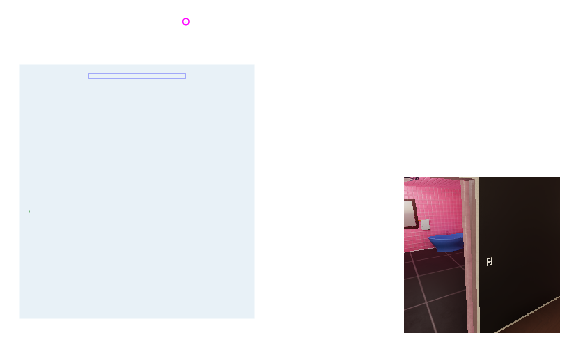

In [487]:
fname = '../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/logs_episode.185_iter.0.pik'
img = visualize_trajectory(fname, gen_vid=True, plot_img=True, plot_belief=True, full_obs=True, frame_end=30)
# img = visualize_trajectory(fname, gen_vid=False, plot_img=True, plot_belief=True, full_obs=True, frame_end=29)


100%|██████████| 1/1 [00:00<00:00, 25.41it/s]

[0]



100%|██████████| 1/1 [00:00<00:00, 13.72it/s]

[20]



100%|██████████| 1/1 [00:00<00:00, 10.56it/s]

[40]



100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

[60]



100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

[80]



100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

[100]



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[120]



  0%|          | 0/1 [00:00<?, ?it/s]

[140]


  0%|          | 0/1 [00:00<?, ?it/s]

[149]


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


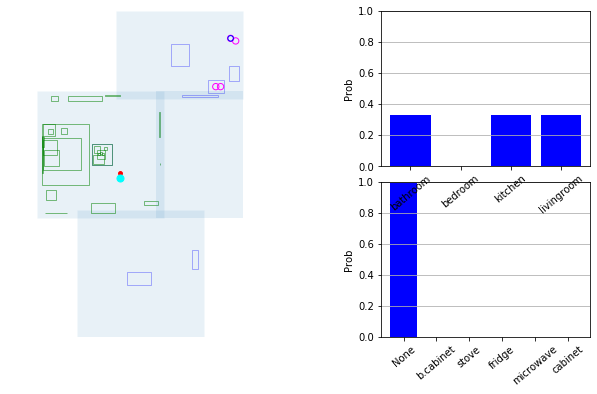

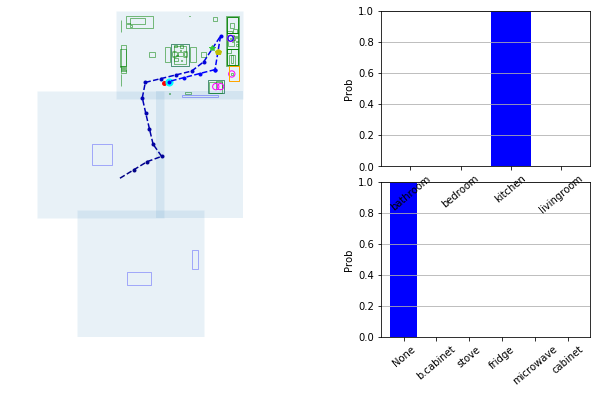

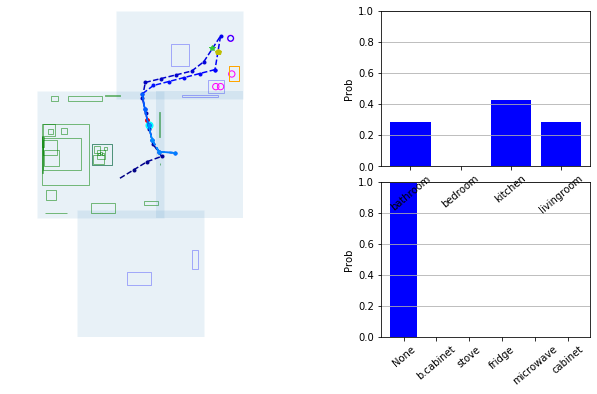

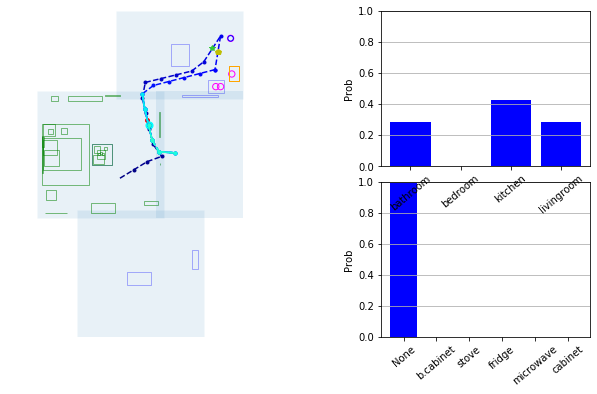

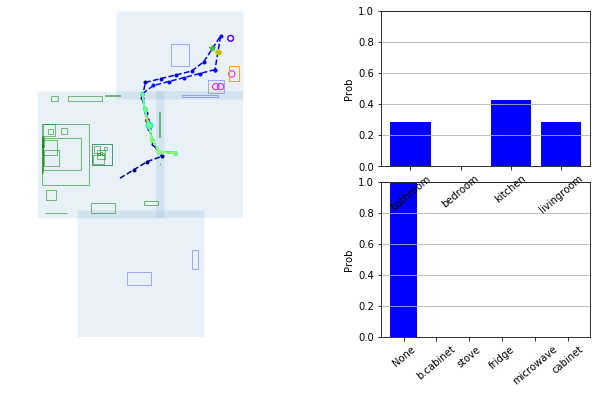

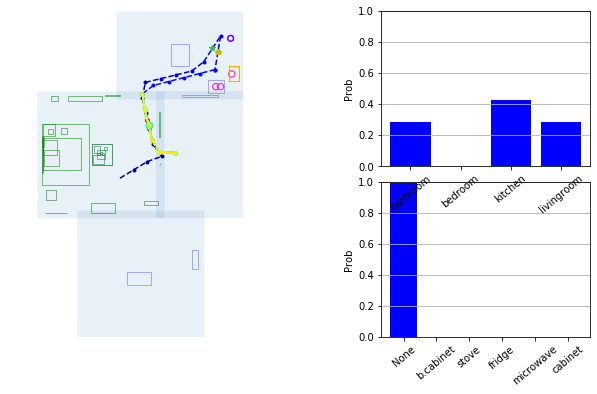

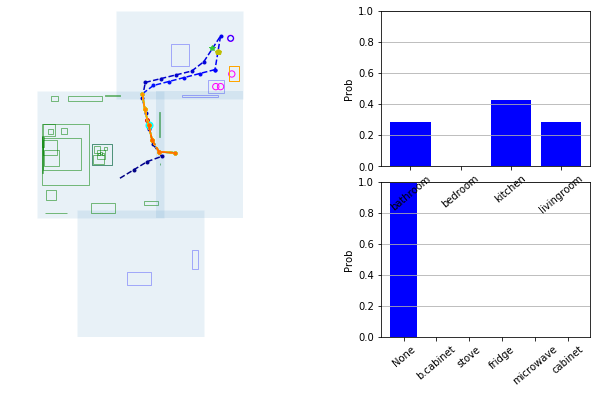

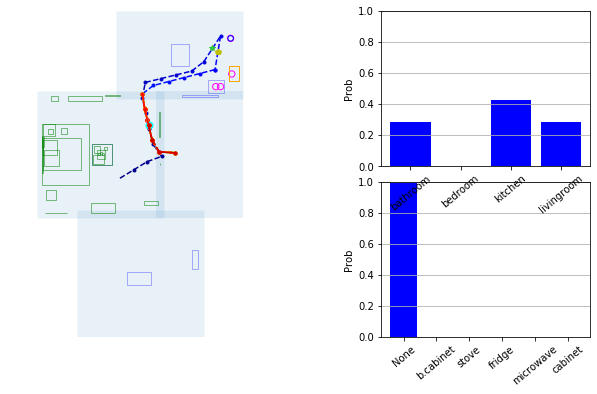

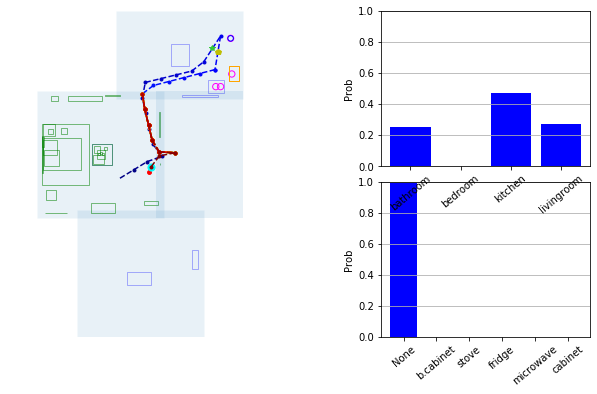

In [27]:
file_inp = '../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/15_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.1v9_particles_v2_modeinfo/logs_episode.185_iter.0.pik'

for fe in [0, 20, 40, 60, 80, 100, 120, 140, 149]:
    img = visualize_trajectory(file_inp, gen_vid=False, 
                               plot_img=False, plot_belief=True, 
                               full_obs=True, belief_id=359, frame_end=fe,
                               plot_special_actions=True)



In [5]:
common_path = '../dataset_episodes/small_data_toy/train_env_task_set_1_full/'
path1 = f'{common_path}/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0'

In [12]:
 ls ../dataset_episodes/small_data_toy/train_env_task_set_1_full/4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0

In [10]:
files

['../dataset_episodes/small_data_toy/train_env_task_set_1_full/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0',
 '../dataset_episodes/small_data_toy/train_env_task_set_1_full/4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0']

../dataset_episodes/small_data_toy/train_env_task_set_1_full/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0/logs_episode.0_iter.0.pik


  0%|          | 0/1 [00:00<?, ?it/s]

[22]


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


../dataset_episodes/small_data_toy/train_env_task_set_1_full/4_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0/logs_episode.0_iter.0.pik


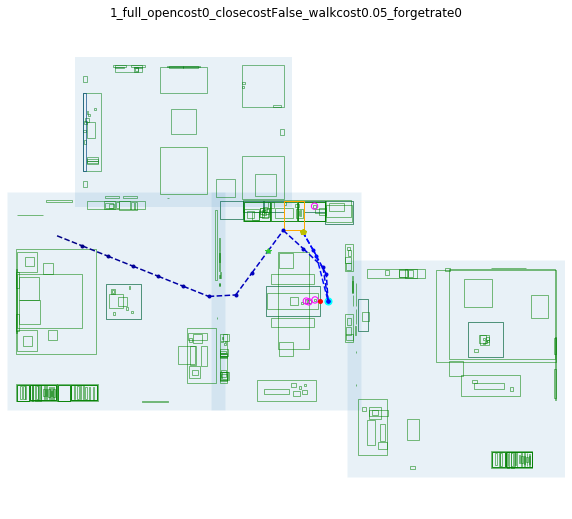

In [8]:
import glob
import os
files = glob.glob(f'{common_path}/*')
files = sorted(files, key=lambda x: int(x.split('/')[-1].split('_')[0]))

for agent_name in files:
    fname = f'{agent_name}/logs_episode.0_iter.0.pik'
    print(fname)
    if os.path.isfile(fname):
        
        img = visualize_trajectory(fname, gen_vid=False, plot_img=False, plot_belief=True, full_obs=True, plot_special_actions=True)
        plt.title(fname.split('/')[-2])

In [488]:
ls -lt ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/*modeinfo/logs*

-rw-rw-r-- 1 xavierpuig vision-torralba  7510206 Apr 14 15:02 ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/logs_episode.202_iter.0.pik
-rw-rw-r-- 1 xavierpuig vision-torralba  4865004 Apr 14 15:02 ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/logs_episode.364_iter.0.pik
-rw-rw-r-- 1 xavierpuig vision-torralba  1631379 Apr 14 15:01 ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/logs_episode.344_iter.0.pik
-rw-rw-r-- 1 xavierpuig vision-torralba  4569153 Apr 14 15:01 ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/logs_episode.78_iter.0.pik
-rw-rw-r-- 1 xavi

In [489]:
def get_location_objects(content, tsteps=[0]):
    goal_obj = [x.split('_')[1] for x, y in content['goals'][0].items() if y > 0]
    goal_name = ['{}: {}'.format(x.split('_')[1], y) for x, y in content['goals'][0].items() if y > 0]
    print(goal_name)
    graph = content['init_unity_graph']
    id2node = {node['id']: node for node in graph['nodes']}
    ids = [node['id'] for node in content['init_unity_graph']['nodes'] if node['class_name'] in goal_obj]
    locations = ['{} {} {}'.format(
        id2node[edge['from_id']]['class_name'],
        edge['relation_type'], 
        id2node[edge['to_id']]['class_name']) for edge in graph['edges'] if edge['from_id'] in ids]
    print("Locations")
    for loc in locations:
        print(loc)
    print("Beliefs")
    for tstep in tsteps:
        beliefs = content['belief'][0][tstep]
        beliefsroom = content['belief_room'][0][tstep]
        print(ids)
        for idi in ids:
            if idi != 357:
                continue
            beliefs_obj = beliefs[idi]['INSIDE']
            prob = scipy.special.softmax(beliefs_obj[1])
            names = ['None' if name is None else id2node[name]['class_name'] for name in beliefs_obj[0]]
            prob_loc = ['{}: {:.2f}'.format(names[it], prob[it]) for it in range(len(names))]
            prob_loc = ' '.join(prob_loc)
            print(idi, id2node[idi]['class_name'], prob_loc)
        
            beliefs_obj = beliefsroom[idi]
            prob = beliefs_obj[1] #scipy.special.softmax(beliefs_obj[1])
            names = ['None' if name is None else id2node[name]['class_name'] for name in beliefs_obj[0]]
            prob_loc = ['{}: {:.2f}'.format(names[it], prob[it]) for it in range(len(names))]
            prob_loc = ' '.join(prob_loc)
            print(idi, id2node[idi]['class_name'], prob_loc)
#             print(idi, id2node[idi]['class_name'], prob_loc_log)

            print('\n')
        
        
# #     print(locations)
    

In [490]:

with open('{}/logs_episode.185_iter.0.pik'.format(files[-4]), 'rb') as f:
    content = pkl.load(f)
print([x for x in content['action'][0] if 'grab' in x or 'put' in x])
get_location_objects(content, tsteps=[0, 15, 30, 31, 32, 36, 40, 80])

['[grab] <apple> (359)', '[putin] <apple> (359) <fridge> (247)', '[grab] <poundcake> (356)', '[putin] <poundcake> (356) <fridge> (247)']
['poundcake: 1', 'apple: 1']
Locations
poundcake INSIDE kitchen
poundcake INSIDE kitchen
apple INSIDE kitchen
apple INSIDE kitchen
poundcake ON oventray
poundcake ON oventray
apple ON kitchencounter
apple ON sink
poundcake INSIDE stove
poundcake INSIDE stove
Beliefs
[356, 357, 358, 359]
357 poundcake None: 0.99 bathroomcabinet: 0.00 stove: 0.00 fridge: 0.00 microwave: 0.00 cabinet: 0.00
357 poundcake bathroom: -1.39 bedroom: -1000000000.00 kitchen: -1.39 livingroom: -1.39


[356, 357, 358, 359]
357 poundcake None: 0.99 bathroomcabinet: 0.00 stove: 0.00 fridge: 0.00 microwave: 0.00 cabinet: 0.00
357 poundcake bathroom: -18.02 bedroom: -18.78 kitchen: -1000000000.00 livingroom: -0.00


[356, 357, 358, 359]
357 poundcake None: 0.99 bathroomcabinet: 0.00 stove: 0.00 fridge: 0.00 microwave: 0.00 cabinet: 0.00
357 poundcake bathroom: -17.32 bedroom: -100000

IndexError: list index out of range

In [491]:
content['belief_room'][0][0][30]

[[11, 73, 170, 259],
 array([-1.38629436e+00, -1.00000000e+09, -1.38629436e+00, -1.38629436e+00])]

In [ ]:
content['belief'][0][0]

In [ ]:
ls ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/1_full_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2

In [ ]:
rm -rf ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone*

In [ ]:
ls -lt ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/


In [ ]:
rm -rf /data/vision/torralba/frames/data_acquisition/SyntheticStories/agent_preferences/agent_preferences/analysis/10_cone*


In [ ]:
ls -lt  ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks_single/10_cone_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2/


In [ ]:
ls -lt  ../../data_scratch/large_data/train_env_task_set_20_full_reduced_tasks1to3/13_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2

In [ ]:
import glob
import os
init_path = '../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks/'
files_agents = sorted(glob.glob(init_path + '*'))
print(files_agents)
for file in files_agents:
    print(file)
    fn = '/logs_episode.0_iter.0.pik'
    fname = file + fn
    if os.path.isfile(fname):
        img = visualize_trajectory(fname, gen_vid=True, plot_belief=False, full_obs=True)
#         plt.imshow(img)

In [ ]:
ls ../../data_scratch/large_data_toy/test_env_task_set_10_full_reduced_tasks_single/6_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0.2v9_particles_v2/

In [ ]:
ls ../../../data_collection_wah/data_analysis/saved_data/planner/logs_agent_58_prepare_food_3/

In [ ]:
import ipdb
import json
import glob

def fill_graph(graph, id2node):
    for node in graph['nodes']:
        node['class_name'] = id2node[node['id']]['class_name']
        node['category'] = id2node[node['id']]['category']
    return graph
def generate_pkl(folder_inp, out_file='out.pkl'):
    files = glob.glob(f'{folder_inp}/file*.json')
    nsteps = len(files)
    actions = []
    graphs = []
    with open(f'{folder_inp}/init_graph.json', 'r') as f:
        content = json.load(f)
    id2node = {node['id']: node for node in content['graph']['nodes']}
    for step in range(nsteps):
#         print(step, nsteps)
        with open(f'{folder_inp}/file_{step}.json', 'r') as f:
            content = json.load(f)
        actions.append(content['instruction'])
        graphs.append(fill_graph(content['graph'], id2node))
#         ipdb.set_trace()
    print(content['predicates'])
    final_c = {
        'graph': graphs,
        'init_graph': graphs[0],
        'goals': {0: content['predicates']}
    }
    with open(out_file, 'wb') as f:
        pkl.dump(final_c, f)
file_inp = '../../../data_collection_wah/record_graph_iclr2020_backup/single_agent_maite/task_58/time.09.25.2020-20.08.42/'
file_inp = '../../../data_collection_wah/data_analysis/saved_data/planner/logs_agent_58_prepare_food_3/'
#generate_pkl(file_inp)
generate_pkl(file_inp, out_file='out_plan.pkl')

In [ ]:
img = visualize_trajectory('out_plan.pkl', gen_vid=True, plot_belief=False, full_obs=True)

In [ ]:
def convert_plot(out_path = 'wah_data/planner_truegoal/', file_input='../data_input/log_agent_0_read_book.pik'):

    out_path_all = out_path + file_input.split('/')[-1].replace('.pik', '')
    if not os.path.isdir(out_path_all):
        os.makedirs(out_path_all)
    with open(file_input, 'rb') as f:
            content = pkl.load(f)

#     ipdb.set_trace()

    obs0 = content['obs'][0]
#     obs1 = content['obs'][1]
    obs_char = [node for node in obs0 if node['id'] == 1][0]
#     obs_char2 = [node for node in obs1 if node['id'] == 2][0]

    with open('{}/init_graph.json'.format(out_path_all), 'w+') as f:
            graph_data = {'graph': content['init_unity_graph']}
            graph_data['graph']['nodes'].append(obs_char)
#             graph_data['graph']['nodes'].append(obs_char2)
            json.dump(graph_data, f)

    all_ids = [1, 2] + [node['id'] for node in graph_data['graph']['nodes']]
    def convert_data(node):
            # print(node)
            new_node = {name: node[name] for name in ['id', 'class_name', 'states', 'bounding_box']}
            if new_node['id'] in [1,2]:
                    new_node['bounding_box']['size'] = [0.75, 0.75, 0.75]
            return new_node


    # ipdb.set_trace()
    # First time an id is used
    first_time_id = {}
    for it in range(len(content['action'][0])):
            ids_obs = [(node['id'], node) for node in content['obs'][it]]
            ids_obs2 = [] #[(node['id'], node) for node in content['obs'][it*2 + 1]]
            for idi, node in ids_obs + ids_obs2:
                    if idi not in first_time_id:
                            first_time_id[idi] = node


    last_id = {}

    for it in range(len(content['action'][0])):
            instr = str(content['action'][0][it]) + ' | ' + str(content['action'][0][it])
#             ipdb.set_trace()
            preds = {it: prd for it, prd in content['goals'][0].items()}
            info = {
                    'instruction': [instr],
                    'predicates': preds
            }
            obs = content['obs'][it]
            obs2 = [] #content['obs'][it]
            graph = {
                    'nodes': obs + obs2,
                    'edges': []
            }
            graph['nodes'] = [convert_data(node) for node in graph['nodes']]
            
            missing_ids = set(all_ids) - set([node['id'] for node in graph['nodes']])
            for missing_id in missing_ids:
                    if missing_id in last_id:
                            graph['nodes'].append(last_id[missing_id])
                    else:
                            if missing_id in first_time_id:
                                    graph['nodes'].append(convert_data(first_time_id[missing_id]))

            # keep track of last ids
            for node in graph['nodes']:
                last_id[node['id']] = node

            info['graph'] = graph
            with open('{}/file_{}.json'.format(out_path_all, it), 'w+') as f:
                    json.dump(info, f)
# conv

In [ ]:
file_inp = '../../../data_collection_wah/record_scratch/rec_good_test/multiAlice_env_task_set_20_check_neurips_test/logs_agent_58_prepare_food_0.pik'
# convert_plot(file_input=file_inp)
generate_pkl('wah_data/planner_truegoal/logs_agent_58_prepare_food_0/', out_file='out_plan_planner.pkl')
#img = visualize_trajectory(file_inp, gen_vid=True, plot_belief=False, full_obs=True)

In [479]:
img = visualize_trajectory('out_plan_planner.pkl', gen_vid=True, plot_belief=False, full_obs=True)

KeyError: 'obs'

In [480]:
with open('../dataset/train_env_task_set_20_full_reduced_tasks.pik', 'rb') as f:
    cont = pkl.load(f)

In [481]:
num_preds = []
for c in cont:
    num_preds.append(sum(c['task_goal'][0].values()))

In [482]:
from collections import Counter
Counter(num_preds)

Counter({4: 113, 2: 165, 3: 162})

In [483]:
c['task_goal']

{0: {'on_cupcake_294': 1,
  'on_juice_294': 0,
  'on_wine_294': 0,
  'on_pudding_294': 0,
  'on_apple_294': 0,
  'holds_book_1': 0,
  'sit_1_292': 1},
 1: {'on_cupcake_294': 1,
  'on_juice_294': 0,
  'on_wine_294': 0,
  'on_pudding_294': 0,
  'on_apple_294': 0,
  'holds_book_1': 0,
  'sit_1_292': 1}}

['[walktowards] <livingroom> (259)', '[walktowards] <livingroom> (259)', '[walktowards] <livingroom> (259)', '[walktowards] <livingroom> (259)', '[walktowards] <cabinet> (318)', '[walktowards] <cabinet> (318)', '[walktowards] <cabinet> (318)', '[open] <cabinet> (318)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[open] <fridge> (247)', '[touch] <cupcake> (352)']


  7%|▋         | 2/28 [00:00<00:01, 15.10it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


100%|██████████| 28/28 [00:01<00:00, 22.81it/s]


_logs_episode.293_iter.0.mp4


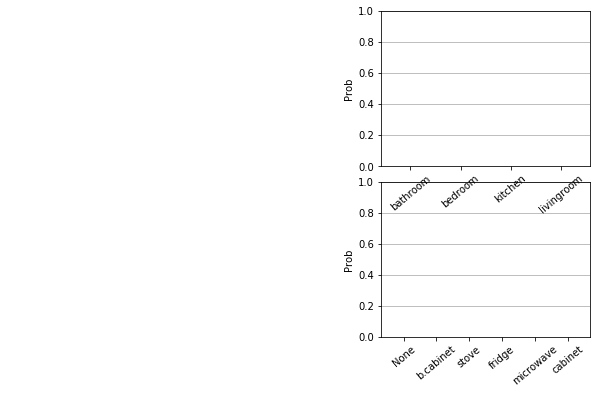

In [19]:
fnames = [
    '5_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/',
    '11_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/',
    '13_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/'
]

fname = fnames[0]
file_inp = f'../../data_scratch/large_data_touch_v2/train_env_task_set_20_full_reduced_tasks1to3/{fname}/logs_episode.293_iter.0.pik'
with open(file_inp, 'rb') as f:
    cont = pkl.load(f)
belief_id = int(cont['action'][0][-1].split('(')[-1][:-1])
last_t = len(cont['action'][0])
print(cont['action'][0])
for fe in [0]:#, last_t-1]:
    img = visualize_trajectory(file_inp, gen_vid=True, 
                               plot_img=False, plot_belief=True, 
                               full_obs=True, belief_id=belief_id, frame_end=fe,
                               plot_special_actions=True)

['[walktowards] <livingroom> (259)', '[walktowards] <livingroom> (259)', '[walktowards] <livingroom> (259)', '[walktowards] <livingroom> (259)', '[walktowards] <cabinet> (318)', '[walktowards] <cabinet> (318)', '[walktowards] <cabinet> (318)', '[open] <cabinet> (318)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <kitchen> (170)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[walktowards] <fridge> (247)', '[open] <fridge> (247)', '[touch] <cupcake> (352)']


100%|██████████| 1/1 [00:00<00:00, 22.50it/s]

[0]



100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

[26]


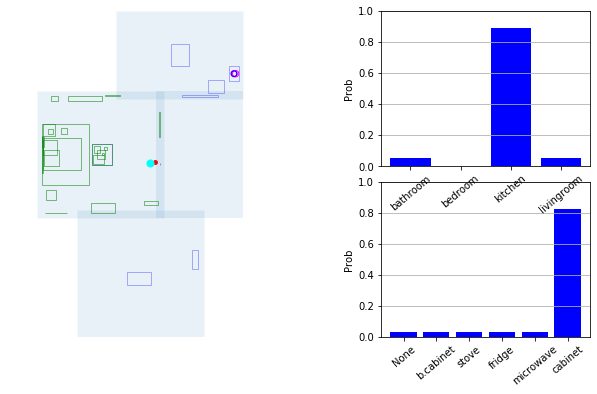

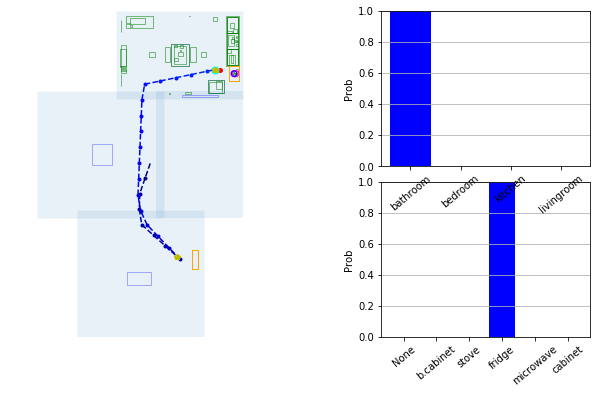

In [15]:
fnames = [
    '5_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/',
    '11_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/',
    '13_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/'
]

fname = fnames[0]
file_inp = f'../../data_scratch/large_data_touch_v2/train_env_task_set_20_full_reduced_tasks1to3/{fname}/logs_episode.293_iter.0.pik'
with open(file_inp, 'rb') as f:
    cont = pkl.load(f)
belief_id = int(cont['action'][0][-1].split('(')[-1][:-1])
last_t = len(cont['action'][0])
print(cont['action'][0])
for fe in [0, last_t-1]:
    img = visualize_trajectory(file_inp, gen_vid=False, 
                               plot_img=False, plot_belief=True, 
                               full_obs=True, belief_id=belief_id, frame_end=fe,
                               plot_special_actions=True)

In [134]:
ls ../../data_scratch/large_data_touch_v2/train_env_task_set_20_full_reduced_tasks1to3/* | wc -l

3354


In [22]:
file_inp = '../../data_scratch/large_data_touch/train_env_task_set_20_full_reduced_tasks1to3/11_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/logs_episode.293_iter.0.pik'
with open(file_inp, 'rb') as f:
    cont = pkl.load(f)


In [62]:
cont['obs'][-1]

[286,
 287,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 341,
 349,
 1,
 359,
 360,
 11,
 73,
 170,
 259]

In [49]:
[edge for edge in cont['init_unity_graph']['edges'] if edge['from_id'] in [352, 353]]

[{'from_id': 352, 'to_id': 170, 'relation_type': 'INSIDE'},
 {'from_id': 353, 'to_id': 170, 'relation_type': 'INSIDE'},
 {'from_id': 352, 'to_id': 247, 'relation_type': 'INSIDE'},
 {'from_id': 353, 'to_id': 247, 'relation_type': 'INSIDE'}]

In [5]:
import sys
sys.path.append('..')
from utils import utils_plot2
import pickle as pkl

In [6]:
file_inp = '../../data_scratch/large_data_touch/train_env_task_set_20_full_reduced_tasks1to3/11_partial_opencost0_closecostFalse_walkcost0.05_forgetrate0v9_particles_v2_modeinfo/logs_episode.293_iter.0.pik'
with open(file_inp, 'rb') as f:
    cont = pkl.load(f)


In [7]:
graph_seq = cont['graph']

In [8]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

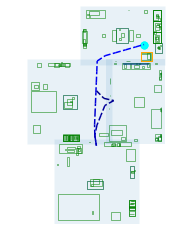

In [9]:
plt.figure()
ax = plt.subplots()
utils_plot2.plot_episode(graph_seq, ax[1])

In [6]:
set([node['class_name'] for node in graph_seq[0]['nodes']])
set([node['category'] for node in graph_seq[0]['nodes']])

{'Appliances',
 'Ceiling',
 'Characters',
 'Coffee_pot_1a',
 'DHP_PRE_Pancakes_1024',
 'DHP_PRE_Pink_cupcake_1024',
 'DHP_PRE_Pudding_1024',
 'Decor',
 'Doors',
 'Electronics',
 'FMGP_PRE_Apple_1024',
 'Floor',
 'Floors',
 'Food',
 'Furniture',
 'Lamps',
 'Props',
 'Rooms',
 'Walls',
 'Windows',
 'Wine_1'}